In [42]:
import numpy as np
import matplotlib.pyplot as plt
import random

from numba import jit

In [43]:
def initial_system_config(N):
    # Define a configuração inicial do sistema
    # S recebe valores aleatórios -1 ou 1
    S = np.random.randint(0,2,N)
    S = 2 * S - 1
    return S

In [44]:
def expos(beta):
    ex = np.zeros(5,dtype=np.float32)
    ex[0]=np.exp(8.0*beta)
    ex[1]=np.exp(4.0*beta)
    ex[2]=1.0
    ex[3]=np.exp(-4.0*beta)
    ex[4]=np.exp(-8.0*beta)
    return ex

In [45]:
@jit(nopython=True)
def vizinhos(N):
    # Define a tabela de vizinhos
    L=int(np.sqrt(N))
    viz = np.zeros((N,4),dtype=np.int16)
    for k in range(N):
        viz[k,0]=k+1
        if (k+1) % L == 0:
            viz[k,0] = k+1-L
        viz[k,1] = k+L
        if k > (N-L-1):
            viz[k,1] = k+L-N
        viz[k,2] = k-1
        if (k % L == 0):
            viz[k,2] = k+L-1
        viz[k,3] = k-L
        if k < L:
            viz[k,3] = k+N-L
    return viz

In [46]:
@jit(nopython=True)
def energy(N, viz, S):
    E = 0.0
    for i in range(N):
        h = S[viz[i,0]] + S[viz[i,1]]
        E += -S[i]*h
    return E

In [47]:
def metroplis_ising(N, T, mc_steps):    
# Passos gerais do algoritmo
    beta = 1/T
    ex = expos(beta)
    S = initial_system_config(N)
    energy_system = []
    magnetizations = []
    viz = vizinhos(N)
    
    for _ in range(mc_steps):
        for spin in range(N):
            h = S[viz[spin,0]] + S[viz[spin,1]] + S[viz[spin,2]] + S[viz[spin,3]] # soma dos vizinhos
            de = int(S[spin] * h * 0.5 + 2)
            if random.random() < ex[de]:  # random.random gera um número aleatório entre 0 e 1
                S[spin] = -S[spin]
        energy_system.append(energy(N, viz, S))   
        magnetizations.append(np.sum(S)) 
    
    return energy_system, magnetizations

# Temperatura está em unidades de j/kB, onde kb é a constante de Boltzmann

In [48]:
def _plot(values, mc_steps, N, T, xlabel='Monte Carlo Step', ylabel='Energy', title='Energy vs MC steps'):
    for value in values:
        plt.plot(mc_steps, value)

    title = f'{title} (N={N}, T={T})'
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [49]:
def plot_random_systems_energy(systems, magnetizations, N, T, mc_steps=1000):
    mc_steps = np.arange(0, mc_steps, 1)
    _plot(systems, mc_steps, N, T)
    _plot(magnetizations, mc_steps, N, T, ylabel='Magnetization', title='Magnetization vs MC steps')

In [50]:
def generate_systems(N_range=[], T_range=[], standard=True, n_systems=10,  mc_steps=1000):
    """
    Função para gerar sistemas aleatórios ou padrões. \n
    No caso de padrões - definido por standard = True - a temperatura é fixa em 1.5 e o tamanho do sistema em 1024 spins. \n
    No caso de aleatórios - definido por standard = False - a temperatura e o tamanho do sistema são gerados aleatoriamente
    dentro dos intervalos definidos por T_range e N_range, respectivamente, que são listas de dois valores.
    """
    energies = []
    magnetizations = []
    
    if standard:
        T = 1.5
        N = 1024
    else:
        T = np.random.uniform(T_range[0], T_range[1])
        N = np.random.randint(N_range[0], N_range[1]) ** 2

    for _ in range(n_systems):
        energy, magnetization = metroplis_ising(N, T, mc_steps)
        energies.append(energy)
        magnetizations.append(magnetization)
        
    return energies, magnetizations, N, T

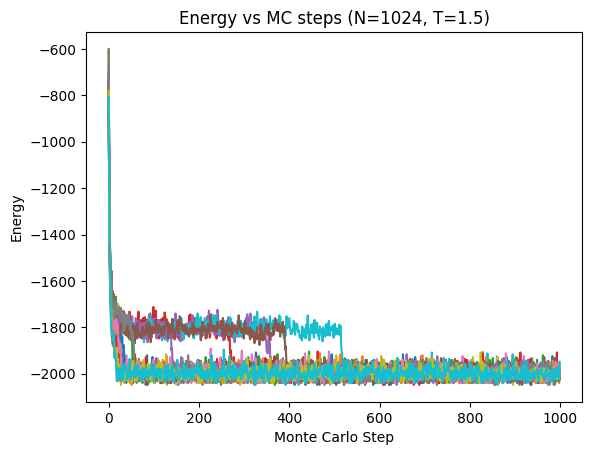

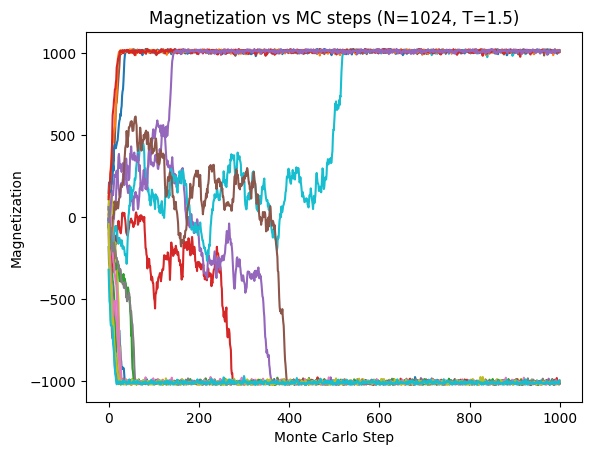

In [51]:
systems, magnetizations, N, T = generate_systems([20, 100], [0.4, 3], n_systems=20)
plot_random_systems_energy(systems, magnetizations, N, T)